In [12]:
using Pkg
Pkg.instantiate()
Pkg.add("MCMCChains")
using TAMode

  Resolving package versions...
   Updating `~/TAMode.jl/Project.toml`
 [no changes]
   Updating `~/TAMode.jl/Manifest.toml`
 [no changes]


In [63]:
using MCMCChains
chn = read("../chain-file-6_26.jls", Chains)
summarize(chn);

In [19]:
Ig2rev = get(chn, :Ig2rev)[1]
scale = get(chn, :scale)[1]
scaleSurf = get(chn, :scaleSurf)[1]

x = get(chn, [:internalize, :pYinternalize, :sortF, :kRec, :kDeg, :xFwd, :gasCur, :AXLexpr]);
samp_params = hcat(x.internalize, x.pYinternalize, x.sortF, x.kRec, x.kDeg, x.xFwd, x.gasCur);

In [56]:
using StaticArrays
using LinearAlgebra
tps = @SVector Float64[1, 60, 360, 720, 1080, 1440] # 1min, 1hr, 6hr, 12hr, 18hr, 24hr
index = 200
# M1
AXLexpr = 44.5        # 4057
MerTKexpr = 0.68    # 86.47
Tyro3expr = 3.5    # 438
params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, Tyro3expr, Ig2rev[index], ones(4));
#params = vcat(internalize, pYinternalize, sortF, kRec, kDeg, xFwd, gasCur, AXLexpr, zeros(2), Ig2rev, ones(4))

In [57]:
pYAXL = TAMode.pY .* TAMode.recpSpecific[1]
surfAXL = TAMode.surface .* TAMode.recpSpecific[1]
totAXL = TAMode.total .* TAMode.recpSpecific[1]

pYMerTK = TAMode.pY .* TAMode.recpSpecific[2]
surfMerTK = TAMode.surface .* TAMode.recpSpecific[2]
totMerTK = TAMode.total .* TAMode.recpSpecific[2]

pYTyro3 = TAMode.pY .* TAMode.recpSpecific[3]
surfTyro3 = TAMode.surface .* TAMode.recpSpecific[3]
totTyro3 = TAMode.total .* TAMode.recpSpecific[3];

In [72]:
paramsStart = TAMode.param(params)
solInit = TAMode.getAutocrine(paramsStart)
paramsStart.gasCur += 10
data = TAMode.runTAMinit(tps, paramsStart, solInit)

6×55 Array{Float64,2}:
 4.9872   28.9143  10.5187  2157.14  …  6.23858  3.74661  235.88   0.0
 3.98343  30.658   13.25    3008.41     3.79625  3.61297  220.888  0.0
 4.04886  33.9954  14.8648  3424.35     4.09999  3.90018  257.169  0.0
 4.04969  34.031   14.8819  3428.74     4.08284  3.88376  255.704  0.0
 4.04969  34.0314  14.8821  3428.79     4.0825   3.88343  255.669  0.0
 4.04969  34.0314  14.8821  3428.79  …  4.08249  3.88343  255.668  0.0

In [73]:
pYA = (data * pYAXL) * scale[index]
surfA = (data * surfAXL) * scaleSurf[index]
totalA = (data * totAXL) # 4067.2585803887146

pYM = (data * pYMerTK) * scale[index]
surfM = (data * surfMerTK) * scaleSurf[index]
totalM = (data * totMerTK) # 85.86830649771866

pYT = (data * pYTyro3) * scale[index]
surfT = (data * surfTyro3) * scaleSurf[index]
totalT = (data * totTyro3); # 440.6731445966876

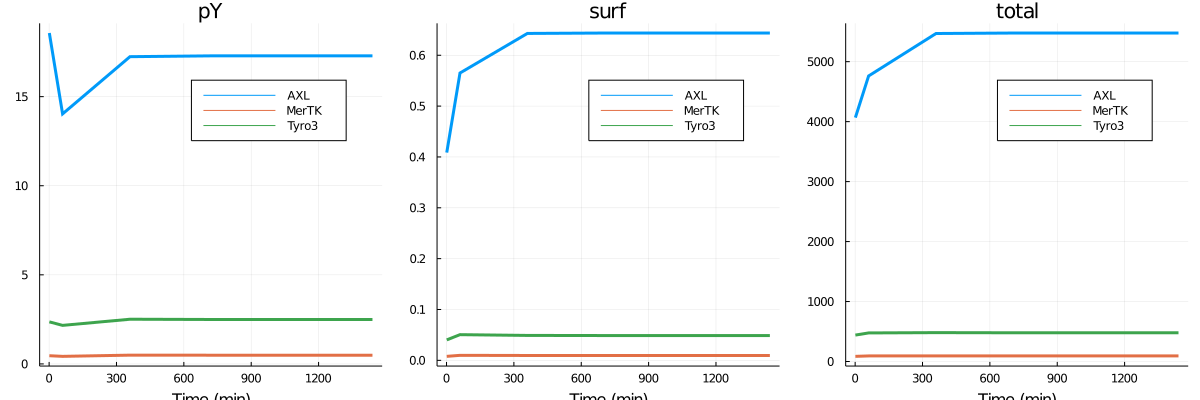

In [97]:
# plotting
using Plots
A = hcat(pYA, surfA, totalA)
M = hcat(pYM, surfM, totalM)
T = hcat(pYT, surfT, totalT)
plot(tps, [A, M, T], lw = 3, 
    xlabel = "Time (min)",
    label = ["AXL" "AXL" "AXL" "MerTK" "MerTK"  "MerTK" "Tyro3" "Tyro3" "Tyro3"], 
    title = ["pY" "surf" "total"], 
    layout = (1,3), size=(1200,400))

In [70]:
# AXL knock down
A_params = vcat(samp_params[index, :], 0, MerTKexpr, Tyro3expr, Ig2rev[index], ones(4));
A_paramsStart = TAMode.param(A_params)
A_solInit = TAMode.getAutocrine(A_paramsStart) # pretty sure solInit is the same, so don't need to do this
A_paramsStart.gasCur += 10
A_data = TAMode.runTAMinit(tps, A_paramsStart, A_solInit)

A_pYA = (A_data * pYAXL) * scale[index]
A_surfA = (A_data * surfAXL) * scaleSurf[index]
A_totalA = (A_data * totAXL) 

A_pYM = (A_data * pYMerTK) * scale[index]
A_surfM = (A_data * surfMerTK) * scaleSurf[index]
A_totalM = (A_data * totMerTK) 

A_pYT = (A_data * pYTyro3) * scale[index]
A_surfT = (A_data * surfTyro3) * scaleSurf[index]
A_totalT = (A_data * totTyro3); 

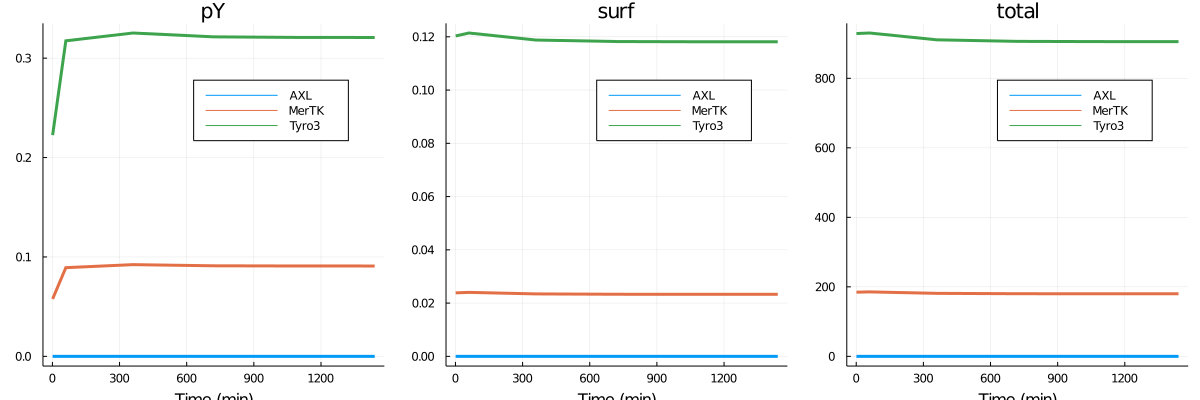

In [99]:
# plotting AXL knock down
A_A = hcat(A_pYA, A_surfA, A_totalA)
A_M = hcat(A_pYM, A_surfM, A_totalM)
A_T = hcat(A_pYT, A_surfT, A_totalT)
plot(tps, [A_A, A_M, A_T], lw = 3, 
    xlabel = "Time (min)",
    label = ["AXL" "AXL" "AXL" "MerTK" "MerTK"  "MerTK" "Tyro3" "Tyro3" "Tyro3"], 
    title = ["pY" "surf" "total"], 
    layout = (1,3), size=(1200,400))

In [71]:
# Tyro 3 knock down
T_params = vcat(samp_params[index, :], AXLexpr, MerTKexpr, 0, Ig2rev[index], ones(4));
T_paramsStart = TAMode.param(T_params)
T_solInit = TAMode.getAutocrine(T_paramsStart)
T_paramsStart.gasCur += 10
T_data = TAMode.runTAMinit(tps, T_paramsStart, T_solInit)

T_pYA = (T_data * pYAXL) * scale[index]
T_surfA = (T_data * surfAXL) * scaleSurf[index]
T_totalA = (T_data * totAXL) # 4067.2585803887146

T_pYM = (T_data * pYMerTK) * scale[index]
T_surfM = (T_data * surfMerTK) * scaleSurf[index]
T_totalM = (T_data * totMerTK) # 85.86830649771866

T_pYT = (T_data * pYTyro3) * scale[index]
T_surfT = (T_data * surfTyro3) * scaleSurf[index]
T_totalT = (T_data * totTyro3); # 440.6731445966876

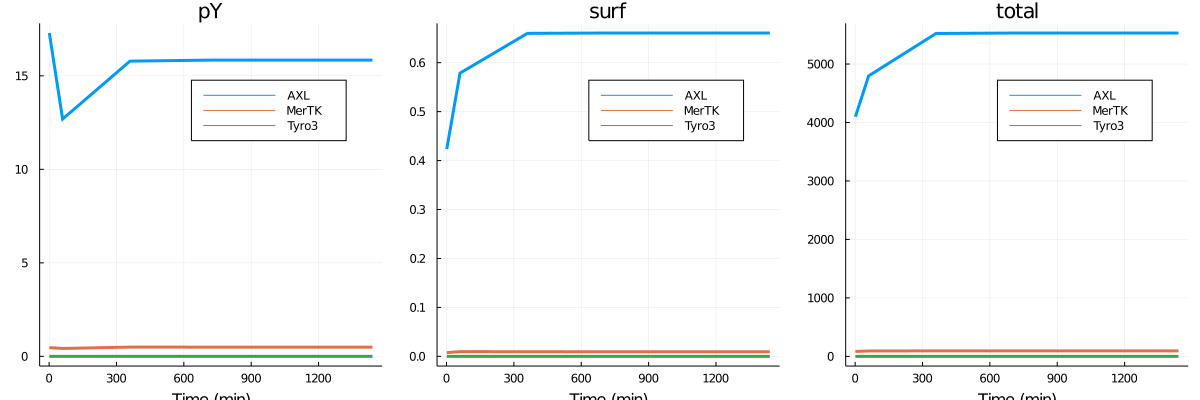

In [100]:
# plotting Tyro3 knock down
T_A = hcat(T_pYA, T_surfA, T_totalA)
T_M = hcat(T_pYM, T_surfM, T_totalM)
T_T = hcat(T_pYT, T_surfT, T_totalT)
plot(tps, [T_A, T_M, T_T], lw = 3, 
    xlabel = "Time (min)",
    label = ["AXL" "AXL" "AXL" "MerTK" "MerTK"  "MerTK" "Tyro3" "Tyro3" "Tyro3"], 
    title = ["pY" "surf" "total"], 
    layout = (1,3), size=(1200,400))